# Exploring the idea of a Double-Wilson distribution

The structure factors of related structures are likely to be strongly correlated. We should be able to exploit this correlation during scaling and merging by constraining the optimization more strongly than by the requirement that structure factors following a Wilson distribution. 
The Wilson distribution derives from a model where each structure factor derives from a 1D (centric) or 2D (acentric) random walk on the real axis or the complex plane, as appropriate. The amplitudes thereof follow the Wilson distributions. A natural extension would be for the corresponding structure factors of two data sets to perform correlated random walks, resulting in a joint multivariate normal distribution of the real and complex components of the (complex) structure factors of the two data sets.

## Possible improvements:
* Kevin suggests using the Wilson distributions themselves as the loss functions in kernel ridge regression

## Getting started

### Imports

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)
import numpy as np
import pandas as pd


In [27]:
import reciprocalspaceship as rs
from reciprocalspaceship.algorithms.scale_merged_intensities import mean_intensity_by_miller_index
import gemmi
import scipy

In [28]:
rs.__version__

'0.9.2'

### Reading in data sets

In [29]:
path="double_wilson_data\\"

mtz1 = "5kvx_phases" # omit .mtz
mtz2 = "5kw3_phases"
ds1 = rs.read_mtz(path + mtz1 + ".mtz")
ds2 = rs.read_mtz(path + mtz2 + ".mtz")
print(ds1.cell)
print(ds2.cell)

ds1.info()

<gemmi.UnitCell(57.57, 57.57, 151.094, 90, 90, 90)>
<gemmi.UnitCell(58.651, 58.651, 151.567, 90, 90, 90)>
<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 34639 entries, (0, 0, 32) to (36, 3, 3)
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype      
---  ------       --------------  -----      
 0   FREE         34639 non-null  MTZInt     
 1   FP           34639 non-null  SFAmplitude
 2   SIGFP        34639 non-null  Stddev     
 3   FC           34639 non-null  SFAmplitude
 4   PHIC         34639 non-null  Phase      
 5   FC_ALL       34639 non-null  SFAmplitude
 6   PHIC_ALL     34639 non-null  Phase      
 7   FWT          34639 non-null  SFAmplitude
 8   PHWT         34639 non-null  Phase      
 9   DELFWT       34639 non-null  SFAmplitude
 10  PHDELWT      34639 non-null  Phase      
 11  FOM          34639 non-null  Weight     
 12  FC_ALL_LS    34639 non-null  SFAmplitude
 13  PHIC_ALL_LS  34639 non-null  Phase      
dtypes: MTZInt(1), Phase(5)

In [30]:
ds2.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 31926 entries, (0, 0, 4) to (36, 11, 4)
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype      
---  ------       --------------  -----      
 0   FREE         31926 non-null  MTZInt     
 1   FP           31926 non-null  SFAmplitude
 2   SIGFP        31926 non-null  Stddev     
 3   FC           31926 non-null  SFAmplitude
 4   PHIC         31926 non-null  Phase      
 5   FC_ALL       31926 non-null  SFAmplitude
 6   PHIC_ALL     31926 non-null  Phase      
 7   FWT          31926 non-null  SFAmplitude
 8   PHWT         31926 non-null  Phase      
 9   DELFWT       31926 non-null  SFAmplitude
 10  PHDELWT      31926 non-null  Phase      
 11  FOM          31926 non-null  Weight     
 12  FC_ALL_LS    31926 non-null  SFAmplitude
 13  PHIC_ALL_LS  31926 non-null  Phase      
dtypes: MTZInt(1), Phase(5), SFAmplitude(6), Stddev(1), Weight(1)
memory usage: 3.4 MB


### Combining data sets

#### Adding reciprocal lattice point coordinates
Let's calculate the reciprocal lattice point coordinates for each reflection.

In [31]:
def ds_add_rs(ds,force_rs=False):
    """
    Adds three columns to an rs dataframe with the reciprocal space coordinates (in A^-1) for each Miller index
    """
    if force_rs or (not "rs_a" in ds.keys()):
        orthomat_list  = ds.cell.orthogonalization_matrix.tolist()
        orthomat = np.asarray(orthomat_list)
    #
        hkl_array = np.asarray(list(ds.index.to_numpy()))
    #
        orthomat_inv_t = np.linalg.inv(orthomat).transpose()
        S = np.matmul(orthomat_inv_t, hkl_array.transpose())
    #    
        ds["rs_a"]=S.transpose()[:,0]
        ds["rs_b"]=S.transpose()[:,1]
        ds["rs_c"]=S.transpose()[:,2]
    else:
        pass
    return ds

In [32]:
ds_add_rs(ds1)
ds_add_rs(ds2)

FREE        FP     SIGFP        FC      PHIC    FC_ALL  PHIC_ALL  \
H  K  L                                                                      
0  0  4      1 146.58742  18.25731   9089.78       0.0 51.228516 179.99648   
      8      1  760.6743  18.64783 4359.6685       0.0 71.819336 359.99973   
      12     1   806.881  19.04429  73.34328       0.0 942.65686 359.99997   
      16     1 108.15088 24.095009 1411.8882     360.0 27.649414 179.99904   
      40     1 1230.5109  23.73836  1318.882       0.0 1359.5361     360.0   
...        ...       ...       ...       ...       ...       ...       ...   
36 11 0      1  45.62726 32.307644  8.469262 359.99985  6.183569 359.99985   
      1      1  48.03641 23.181337  8.960331 87.091415 4.8729806  96.54491   
      2      1  69.61291 28.818678 32.680573  56.66249 20.948725  54.91262   
      3      1 50.914078 24.103708 54.524307 101.27435  34.45759 102.60958   
      4      0 80.052414 35.720814   43.4483  90.54736 27.763554  91.24825   

               FWT      PHWT    DELFWT   PHDELWT         FOM  FC_ALL_LS  \
H  K  L                                                                   
0  0  4  35.293854  359.9965  86.52237  359.9965  0.05435208  882.69336   
      8   573.3724 359.99973 501.55304 359.99973  0.42409196  80.376465   
      12 671.10376 359.99997  271.5531 179.99997  0.99999917  1030.6932   
      16 20.149578 359.99905 47.798992 359.99905 0.034673024  43.045532   
      40 1101.4856     360.0 258.05054     180.0         1.0  1326.5276   
...            ...       ...       ...       ...         ...        ...   
36 11 0   7.259904 359.99985  1.076335 359.99985  0.14731844   8.660954   
      1  6.6845155  96.54491 1.8115345  96.54491 0.120299324   8.747897   
      2    48.6522  54.91262 27.703474 54.912617  0.49991396   32.72222   
      3  31.775106 102.60958 2.6824832 282.60956    0.650436  54.488907   
      4  27.763554  91.24825       0.0       0.0         0.0  43.506428   

           PHIC_ALL_LS    rs_a     rs_b      rs_c  
H  K  L                                            
0  0  4      179.99974  0.0000  0.00000  0.026391  
      8      180.00029  0.0000  0.00000  0.052782  
      12     359.99997  0.0000  0.00000  0.079173  
      16 0.00062703155  0.0000  0.00000  0.105564  
      40         360.0  0.0000  0.00000  0.263910  
...                ...     ...      ...       ...  
36 11 0      359.99985  0.6138  0.18755  0.000000  
      1       88.35271  0.6138  0.18755  0.006598  
      2      56.394043  0.6138  0.18755  0.013195  
      3      101.47542  0.6138  0.18755  0.019793  
      4       90.65295  0.6138  0.18755  0.026391  

[31926 rows x 17 columns]

#### Combining data sets in a joint data frame
Let's combine ("merge" in pandas jargon) the data frames of the two datasets. We'll add the ratios of the observed structure factor amplitudes as columns. In a perfect world, we'd also make sure all the dtypes are what they should be.

In [33]:
ds1_2= ds1.merge(ds2, left_index=True, right_index=True, suffixes=("_1", "_2"))
ds1_2["gamma_pp"] = ds1_2["FP_2"]/ds1_2["FP_1"]
ds1_2.compute_dHKL(inplace=True)
ds1_2.label_centrics(inplace=True)
ds1_2.compute_multiplicity(inplace=True)
ds1_2.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 30126 entries, (0, 0, 40) to (36, 3, 3)
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype      
---  ------         --------------  -----      
 0   FREE_1         30126 non-null  MTZInt     
 1   FP_1           30126 non-null  SFAmplitude
 2   SIGFP_1        30126 non-null  Stddev     
 3   FC_1           30126 non-null  SFAmplitude
 4   PHIC_1         30126 non-null  Phase      
 5   FC_ALL_1       30126 non-null  SFAmplitude
 6   PHIC_ALL_1     30126 non-null  Phase      
 7   FWT_1          30126 non-null  SFAmplitude
 8   PHWT_1         30126 non-null  Phase      
 9   DELFWT_1       30126 non-null  SFAmplitude
 10  PHDELWT_1      30126 non-null  Phase      
 11  FOM_1          30126 non-null  Weight     
 12  FC_ALL_LS_1    30126 non-null  SFAmplitude
 13  PHIC_ALL_LS_1  30126 non-null  Phase      
 14  rs_a_1         30126 non-null  float64    
 15  rs_b_1         30126 non-null  float64    
 16  

#### Checking calculation of reciprocal space coordinates.

C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Doeke Hekstra\.conda\envs\crystallography\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


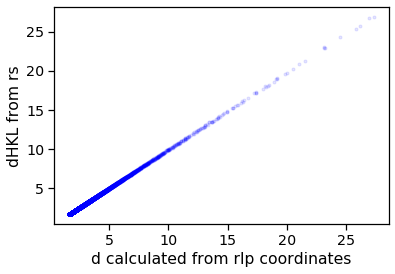

In [34]:
plt.plot(np.sqrt(1/(ds1_2["rs_a_2"]**2 +ds1_2["rs_b_2"]**2 +ds1_2["rs_c_2"]**2)), ds1_2["dHKL"],'b.',alpha=0.1)
plt.xlabel('d calculated from rlp coordinates'), plt.ylabel('dHKL from rs')
plt.show()

#### Checking reciprocal space (ASU) coverage
Let's see what chunk of reciprocal space these reflections are located in. I can't recall how I got this figure to be interactive.

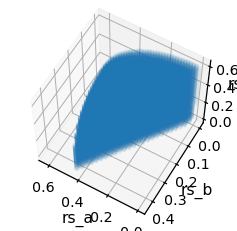

In [35]:
from mpl_toolkits import mplot3d

plt.ion
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection="3d")
ax.scatter3D(ds1["rs_a"], ds1["rs_b"], ds1["rs_c"],alpha=0.05)
ax.view_init(elev=60., azim=1200.)
ax.set_xlabel("rs_a")
ax.set_ylabel("rs_b")
ax.set_zlabel("rs_c")
plt.draw()

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

## Anisotropic scaling

Let's start by setting a training set and test set. Because of the way the loss function below is constructed, we can just pass on entire data frames.

Anisotropic scaling seems to work well for very closely related data sets (e.g. different temperatures), but not for, e.g. apo/liganded pairs.

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds1_2, ds1_2, test_size=0.3, random_state=42)

### Loss functions
Let's define our loss function. It also outputs corrected structure factors, if we want them.

In [37]:
import time

def anisotropic_scaling_train_model(p, ds_a, ds_b,nargout=1):
    """
    Assumes rs dataframes with obtained from merging two data sets (in the pandas sense),
    First with keys FP_1, SIGFP_1, rs_a_1, rs_b_1, rs_c_1; second with keys FP_2, SIGFP_2.
    The first one is scaled to the second one with input parameters p such that 
    B = [[p0, p1, p2], [p1, p3, p4], [p2, p4, p5]].
    
    Returns an error-weighted residual.
    """
    
    rlp      = ds_a[["rs_a_1", "rs_b_1", "rs_c_1"]].to_numpy()
    
    B        = np.asarray([[p[0],p[1],p[2]],[p[1],p[3],p[4]],[p[2],p[4],p[5]]])
    B_corr   = np.exp(-np.sum(rlp * (B @ rlp.transpose()).transpose(),axis=1)).reshape(-1,1)
    
    FP_corr  = p[6]*B_corr * ds_a["FP_1"].to_numpy().reshape(-1,1)
    residual = ds_b["FP_2"].to_numpy().reshape(-1,1) - FP_corr
    #print(FP_corr)
    
    err_a = ds_a["SIGFP_1"].to_numpy()
    err_b = ds_b["SIGFP_2"].to_numpy()
    quad_error = np.sqrt(err_a**2 + err_b**2)
    residual = residual/quad_error.reshape(-1,1)
    
    if nargout == 1:
        return residual.flatten()
    else:
        return residual.flatten(), FP_corr, B_corr

def anisotropic_scaling_to_1(p, ds_a, label, nargout=1):
    """
    Assumes rs dataframes with obtained from merging two data sets (in the pandas sense),
    with keys FP_1, SIGFP_1, rs_a_1, rs_b_1, rs_c_1. This df is scaled to all ones, using
    input parameters p such that B = [[p0, p1, p2], [p1, p3, p4], [p2, p4, p5]].
    
    Returns an error-weighted residual.
    """
    
    rlp      = ds_a[["rs_a_1", "rs_b_1", "rs_c_1"]].to_numpy()
    
    B        = np.asarray([[p[0],p[1],p[2]],[p[1],p[3],p[4]],[p[2],p[4],p[5]]])
    B_corr   = np.exp(-np.sum(rlp * (B @ rlp.transpose()).transpose(),axis=1)).reshape(-1,1)
    FP_corr  = p[6]*B_corr * ds_a[label].to_numpy().reshape(-1,1)
    
    residual = (1.0 - FP_corr)
    
    err_a = ds_a["SIG" + label].to_numpy()
    residual = residual/err_a.reshape(-1,1)
    
    if nargout == 1:
        return residual.flatten()
    else:
        return residual.flatten(), FP_corr, B_corr

In [38]:
print(np.min(ds1_2["FP_2"].to_numpy()/ds1_2["SIGFP_2"].to_numpy()))

1.3304948


### Optimization: scaling data set 1 to data set 2
Next, we set up a robust nonlinear least-squares regression.

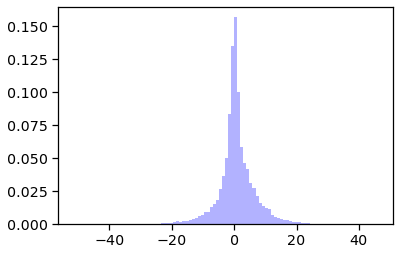

In [39]:
from scipy.optimize import least_squares
res_robust   = least_squares(anisotropic_scaling_train_model, [1,0,0,1,0,1,1], loss='cauchy', f_scale=1, args=(X_train, y_train))
# with a round of outlier rejection:
#res_robust_2 = least_squares(anisotropic_scaling_model, res_robust.x,  loss='soft_l1', f_scale=1, 
#                             args=(X_train.loc[np.abs(res_robust.fun)<np.percentile(np.abs(res_robust.fun),98)], 
#                                   y_train.loc[np.abs(res_robust.fun)<np.percentile(np.abs(res_robust.fun),98)]))
plt.hist(res_robust.fun,100, alpha=0.3,color='b', density=True)
#plt.hist(np.abs(res_robust_2.fun),100, alpha=0.3,color='r', density=True)
plt.show()

We can extract the predicted ratios for the test set. We're using the loss function above for this purpose.

0.3270118862899039
Slope: 1.3423297840087534, intercept: -0.002747883840927834


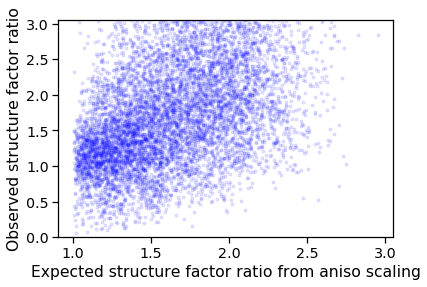

In [40]:
from sklearn.metrics import r2_score
test,  fp_corr,  B_corr = anisotropic_scaling_train_model(res_robust.x, X_test, y_test, nargout=3)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(B_corr.flatten(), y_test["gamma_pp"].to_numpy())
print(r_value)
print("Slope: " + str(slope) + ", intercept: " + str(intercept))

plt.plot(B_corr.flatten(), y_test["gamma_pp"].to_numpy(),'b.',alpha=0.1)
plt.xlabel('Expected structure factor ratio from aniso scaling')
plt.ylabel('Observed structure factor ratio')
plt.ylim((0,plt.xlim()[1]))
plt.show()

### Adding scaled FP1 to the joint dataframe
Adding the anisotropically scaled FP_1 and SIGFP_1 to the joint dataframe.

In [41]:
test2, fp_corr2, B_corr2 = anisotropic_scaling_train_model(res_robust.x, ds1_2, ds1_2, nargout=3)
ds1_2["FP_1_scaled"] = fp_corr2.flatten()
ds1_2["SIGFP_1_scaled"] = B_corr2.flatten() * ds1_2["SIGFP_1"]
ds1_2.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 30126 entries, (0, 0, 40) to (36, 3, 3)
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype      
---  ------          --------------  -----      
 0   FREE_1          30126 non-null  MTZInt     
 1   FP_1            30126 non-null  SFAmplitude
 2   SIGFP_1         30126 non-null  Stddev     
 3   FC_1            30126 non-null  SFAmplitude
 4   PHIC_1          30126 non-null  Phase      
 5   FC_ALL_1        30126 non-null  SFAmplitude
 6   PHIC_ALL_1      30126 non-null  Phase      
 7   FWT_1           30126 non-null  SFAmplitude
 8   PHWT_1          30126 non-null  Phase      
 9   DELFWT_1        30126 non-null  SFAmplitude
 10  PHDELWT_1       30126 non-null  Phase      
 11  FOM_1           30126 non-null  Weight     
 12  FC_ALL_LS_1     30126 non-null  SFAmplitude
 13  PHIC_ALL_LS_1   30126 non-null  Phase      
 14  rs_a_1          30126 non-null  float64    
 15  rs_b_1          30126 non-null 

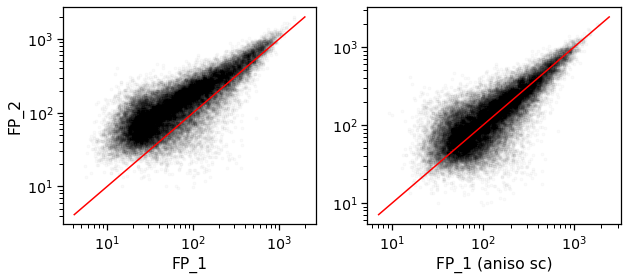

In [42]:
plt.figure(1,figsize=(10,4))
plt.subplot(1,2, 1)
plt.loglog(ds1_2["FP_1"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1"), plt.ylabel("FP_2")
plt.plot(plt.xlim(),plt.xlim(),'r-')

plt.subplot(1,2, 2)
plt.loglog(ds1_2["FP_1_scaled"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1 (aniso sc)")
plt.plot(plt.xlim(),plt.xlim(),'r-')

plt.show()

### Normalizing both datasets by anisotropic scaling

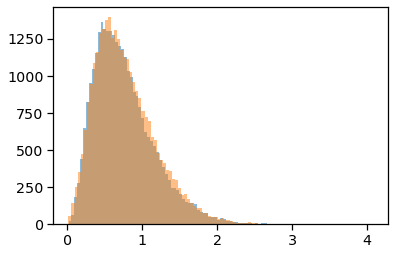

In [45]:
res_robust   = least_squares(anisotropic_scaling_to_1, [1,0,0,1,0,1,1], loss='soft_l1', f_scale=0.1, args=(ds1_2,"FP_1",1))
res_test, fp_corr1, B_corr1 = anisotropic_scaling_to_1(res_robust.x, ds1_2, label="FP_1",nargout=3)
ds1_2["EP_1_aniso"] = fp_corr1.flatten()
ds1_2["SIGEP_1_aniso"] = (fp_corr1.flatten()/ds1_2["FP_1"].to_numpy()) * ds1_2["SIGFP_1"]

res_robust   = least_squares(anisotropic_scaling_to_1, [1,0,0,1,0,1,1], loss='soft_l1', f_scale=0.1, args=(ds1_2,"FP_2",1))
res_test, fp_corr2, B_corr2 = anisotropic_scaling_to_1(res_robust.x, ds1_2, label="FP_2",nargout=3)
ds1_2["EP_2_aniso"] = fp_corr2.flatten()
ds1_2["SIGEP_2_aniso"] = (fp_corr2.flatten()/ds1_2["FP_2"].to_numpy()) * ds1_2["SIGFP_2"]

plt.hist(fp_corr1.flatten(),100,alpha=0.5)
plt.hist(fp_corr2.flatten(),100,alpha=0.5)
plt.show()

#### Correlation coefficients with scaled and unscaled data

In [46]:
def compute_meanF_byres(ds, label="FP", nbins=20,sigma_cut=0, median=False):
    #print(ds.shape)
    if sigma_cut > 0:
        incl_criteria = ds[label].to_numpy().flatten() > sigma_cut * ds["SIG" + label].to_numpy().flatten()
        ds2 = ds[incl_criteria]
    else:
        ds2=ds
    
    ds2, bin_labels = ds2.assign_resolution_bins(bins=nbins)
    if median:
        print("Average observations per bin: " + str(ds2["bin"].value_counts().median()))
        result = ds2.groupby("bin")[label].median()
    else:
        print("Average observations per bin: " + str(ds2["bin"].value_counts().mean()))
        result = ds2.groupby("bin")[label].mean()
    return result, bin_labels

def compute_cc(ds, labels=["F1","F2"], nbins=20):
    ds, bin_labels = ds.assign_resolution_bins(bins=nbins)
    print("Average observations per bin: " + str(ds["bin"].value_counts().mean()))
    g = ds.groupby("bin")[labels]
    result = g.corr(method="spearman").unstack().loc[:, (labels[0],labels[1])]
    return result, bin_labels

def plot_by_res_bin(result, bin_labels, ylabel=r"$CC_{1/2}$",color='b'):
    plt.plot(result, label="Data",color=color)
    plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
    plt.ylabel(ylabel)
    plt.xlabel(r"Resolution Bin ($\AA$)")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim(0, )
    plt.grid(linestyle='--')
    #plt.tight_layout()
    #plt.show()
    return

Let's examine the average SF amplitude by resolution.

Average observations per bin: 1506.0
Average observations per bin: 1506.0
Average observations per bin: 1506.0


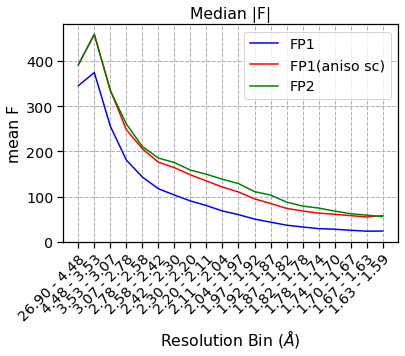

In [47]:
result, bin_labels = compute_meanF_byres(ds1_2, label="FP_1", nbins=20,sigma_cut=0, median=True)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')

result, bin_labels = compute_meanF_byres(ds1_2, label="FP_1_scaled", nbins=20,sigma_cut=0,median=True)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='r')

result, bin_labels = compute_meanF_byres(ds1_2, label="FP_2", nbins=20,sigma_cut=0, median=True)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='g')

plt.title("Median |F|")
plt.legend(["FP1", "FP1(aniso sc)", "FP2"])
plt.ylim(0,)
plt.show()

Average observations per bin: 1506.3
Average observations per bin: 1506.3


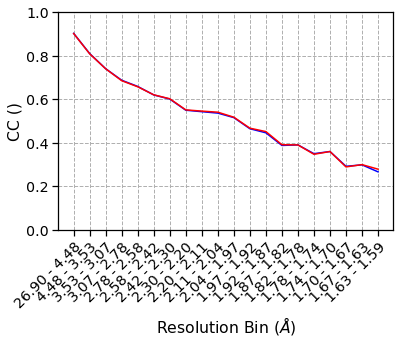

In [48]:
result_1, labels_1 = compute_cc(ds1_2,labels=["FP_1","FP_2"],nbins=20)
result_2, labels_2 = compute_cc(ds1_2,labels=["FP_1_scaled","FP_2"],nbins=20)
plot_by_res_bin(result_1, labels_1,)
plot_by_res_bin(result_2, labels_2,color='r')
plt.ylim(0,1)
plt.ylabel("CC ()")
plt.show()

## Kernel ridge regression est of Sigma
We're estimating $<|F|^2>$ locally in reciprocal space! Because the expected intensity is the same for acentric and centric reflections, we can do this in one go for all of them.

By Rupp eq. (7-104): $ \Sigma_N = \left<I\right>/\varepsilon_h $

In [23]:
temp = ds1_2["EPSILON"][ds1_2["CENTRIC"].to_numpy()==True]
print("Distribution of multiplicities for centric reflections:")
print(temp.value_counts())
print("")

temp = ds1_2["EPSILON"][ds1_2["CENTRIC"].to_numpy()==False]
print("Distribution of multiplicities for acentric reflections:")
print(temp.value_counts())


Distribution of multiplicities for centric reflections:
1    3561
2      16
4       4
Name: EPSILON, dtype: int64

Distribution of multiplicities for acentric reflections:
1    26545
Name: EPSILON, dtype: int64


Kernel ridge regression: see https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
default loss function is the MSE. GridsearchCV performs, by default, 5-fold cross-validation for each set of parameters. Because of this, we use the full data set.

In [24]:
# perhaps it's worth making this a method.
def sigma_cut_ds(ds, F_col="FP", sigF_col="SIGFP", sigma_cut=3):
    if sigma_cut > 0:
        incl_criteria = ds[F_col].to_numpy().flatten() > sigma_cut * ds[sigF_col].to_numpy().flatten()
        ds2 = ds[incl_criteria]
    else:
        ds2=ds
    return ds2

In [25]:
import os.path
from os import path as os_path
import pickle

if os_path.exists(path + mtz1 + "_krr.pkl") & os_path.exists(path + mtz2 + "_krr.pkl"):
    print("Strongly consider skipping the next cell! It takes 30-60 min")
    kr_1 = pickle.load(open(path + mtz1 + "_krr.pkl", 'rb'))
    kr_2 = pickle.load(open(path + mtz2 + "_krr.pkl", 'rb'))
else:
    print("No kernel ridge-regression has been performed yet!")

Strongly consider skipping the next cell! It takes 30-60 min


In [ ]:
from sklearn.metrics import make_scorer

def wilson_dist_I_log_pdf(E, centric=False):
    if centric:
        P_E = np.sqrt(2/np.pi)*np.exp(-0.5*E**2) 
    else:
        P_E = 2*E*np.exp(-E**2)
    return P_E

>>> ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [ ]:
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

# consider adding pre-processing
gridsearch = False # it takes up to an hour
# this will take a few minutes:
# GridsearchCV 
#   1st try   (alpha=1,  gamma=100, kernel='rbf'), with alpha and gamma at the top of the initial ranges.
#   2nd try   (alpha=10, gamma=100, kernel='rbf'), with alpha, but not gamma, at the top of the range
#   3rd try   (alpha=30, gamma=100, kernel='rbf'), with alpha in [10,30,100], gamma fixed.
# on 3rd try switched to neg_mean_absolute_error (from MSE)

if gridsearch: # for regression hyperparameter optimization -- needs some tweaking
    kr_1 = GridSearchCV(KernelRidge(kernel='rbf'), scoring='neg_mean_absolute_error',
                      param_grid={"alpha": [300, 100, 30, 10],
                                  "gamma": [300, 100, 30, 10]})
    kr_1.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]], (ds1_2[["FP_1"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
    kr_2 = GridSearchCV(KernelRidge(kernel='rbf'), scoring='neg_mean_absolute_error',
                      param_grid={"alpha": [300, 100, 30, 10],
                                  "gamma": [300, 100, 30, 10]})
    kr_2.fit(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]], (ds1_2[["FP_2"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
else:
    kr_1 = KernelRidge(kernel='rbf', alpha=30, gamma=100)
    kr_2 = KernelRidge(kernel='rbf', alpha=30, gamma=100)
    kr_1.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]], (ds1_2[["FP_1"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
    kr_2.fit(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]], (ds1_2[["FP_2"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())

pickle.dump(kr_1, open(path + mtz1 + "_krr.pkl",'wb'))
pickle.dump(kr_2, open(path + mtz2 + "_krr.pkl",'wb'))

In [ ]:
if gridsearch:
    kr.best_estimator_

#### Calculate normalized structure factors
Note: we've estimated $\Sigma$. To get normalized structure factors, $E_h=\frac{F_h}{\sqrt{\varepsilon \Sigma_h}}$, we need to do the following:

In [ ]:
Sigma_kr_1 = kr_1.predict(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]])
Sigma_kr_2 = kr_2.predict(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]])

In [ ]:
E1    = ds1_2["FP_1"   ].to_numpy().reshape(-1,1)/np.sqrt(Sigma_kr_1 * ds1_2["EPSILON"].to_numpy().reshape(-1,1))
E2    = ds1_2["FP_2"   ].to_numpy().reshape(-1,1)/np.sqrt(Sigma_kr_2 * ds1_2["EPSILON"].to_numpy().reshape(-1,1))
SIGE1 = ds1_2["SIGFP_1"].to_numpy().reshape(-1,1)/np.sqrt(Sigma_kr_1 * ds1_2["EPSILON"].to_numpy().reshape(-1,1))
SIGE2 = ds1_2["SIGFP_2"].to_numpy().reshape(-1,1)/np.sqrt(Sigma_kr_2 * ds1_2["EPSILON"].to_numpy().reshape(-1,1))

ds1_2["EP_1"]    = E1.flatten()
ds1_2["EP_2"]    = E2.flatten()
ds1_2["SIGEP_1"] = SIGE1.flatten()
ds1_2["SIGEP_2"] = SIGE2.flatten()

Let's what, if anything, happened to the correlations per resolution shell.

In [ ]:
result_1, labels_1 = compute_cc(ds1_2,labels=["FP_1","FP_2"],nbins=20)
result_2, labels_2 = compute_cc(ds1_2,labels=["FP_1_scaled","FP_2"],nbins=20)
result_3, labels_3 = compute_cc(ds1_2,labels=["EP_1","EP_2"],nbins=20)
plot_by_res_bin(result_1, labels_1,)
plot_by_res_bin(result_2, labels_2,color='r')
plot_by_res_bin(result_3, labels_3,color='g')
plt.legend(["FP1-FP2", "FP1(sc)-FP2", "EP1-EP2"])
plt.ylim(0,1)
plt.ylabel("CC ()")
plt.show()

Normalization condenses the range of the structure factor amplitudes quite a bit.

In [ ]:
plt.figure(1,figsize=(10,4))
plt.subplot(1,2, 1)
plt.loglog(ds1_2["FP_1"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1"), plt.ylabel("FP_2")
xl=plt.xlim()
plt.ylim(xl)
plt.plot(xl,xl,'r-')

plt.subplot(1,2, 2)
plt.loglog(ds1_2["EP_1"], ds1_2["EP_2"],'k.',alpha=0.01)
plt.xlabel("EP_1")
xl2=plt.xlim()
plt.plot(xl2,xl2,'r-')
plt.xlim((xl2[0],xl2[0]*xl[1]/xl[0])) # force to have the same range as the left panel
plt.ylim((xl2[0],xl2[0]*xl[1]/xl[0])) # force to have the same range as the left panel
plt.show()

In [ ]:
def wilson_dist_normalized(E, centric=False):
    if centric:
        P_E = np.sqrt(2/np.pi)*np.exp(-0.5*E**2) 
    else:
        P_E = 2*E*np.exp(-E**2)
    return P_E

Let's see how well the structure factor amplitudes fit the Wilson distributions.

In [ ]:
bins=np.linspace(0,5,50)

xl=(0,5)
plt.figure(1,figsize=(10,10))
plt.subplot(2,2, 1)
plt.hist(ds1_2["EP_1"][ds1_2["CENTRIC"].to_numpy()==False],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=False),'r-')
plt.title("Distribution of acentric E")
plt.xlabel("E")
plt.xlim(xl)

plt.subplot(2,2, 2)
plt.hist(ds1_2["EP_1"][ds1_2["CENTRIC"].to_numpy()==True],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=True),'r-')
plt.title("Distribution of centric E")
plt.xlabel("E")
plt.legend(["Expected","Observed"])
plt.xlim(xl)

plt.subplot(2,2, 3)
plt.hist(ds1_2["EP_2"][ds1_2["CENTRIC"].to_numpy()==False],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=False),'r-')
plt.title("Distribution of acentric E")
plt.xlabel("E")
plt.xlim(xl)

plt.subplot(2,2, 4)
plt.hist(ds1_2["EP_2"][ds1_2["CENTRIC"].to_numpy()==True],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=True),'r-')
plt.title("Distribution of centric E")
plt.xlabel("E")
plt.legend(["Expected","Observed"])
plt.xlim(xl)

plt.show()

Interpretation: The deviations at low E seem to be attributable to weak reflections tending to be systematically excluded from the data (verify!), and/or an artefact from FW. **Do we have a good way to make a plot of completeness v resolution?**. 

## Conditional PDFs for normalized structure factors

In [ ]:
from scipy.stats import rice
from scipy.stats import foldnorm

### Benchmarks using synthetic data
We'll first examine some synthetic data generated from the Double-Wilson distribution.

#### a. synthetic data generation & graphical inspection (acentric)

In [ ]:
nsamples=100000
nbin=25
x=np.linspace(0,5,100) # x-coordinates for plots
r=0.8                  # correlation between random walks 
mean=[0,0,0,0]         # mean of random walks
cov=0.5*np.asarray([[1,0,r,0],[0,1,0,r],[r,0,1,0],[0,r,0,1]])

E_1x_1y_2x_2y = np.random.multivariate_normal(mean=mean, cov=cov,size=nsamples)
print(E_1x_1y_2x_2y.shape)

# fake data set (acentric)
ds_test = pd.DataFrame(np.sqrt(E_1x_1y_2x_2y[:,0]**2 +E_1x_1y_2x_2y[:,1]**2 ), columns = ["EP_1"])
ds_test["EP_2"] = pd.DataFrame(np.sqrt(E_1x_1y_2x_2y[:,2]**2 +E_1x_1y_2x_2y[:,3]**2 ))

# graphical inspection
plt.figure()
plt.hist(ds_test["EP_1"].to_numpy(),100,density=True)
plt.plot(x, wilson_dist_normalized(x, centric=False),'r-')
plt.legend(["Acentric Wilson", "Fake observed E (acentric)"])
plt.show()

#### b. synthetic data generation & graphical inspection (centric)
Now the same inspection for centric reflections. Note the subtle factor 2 resulting from multiplicity.

In [ ]:
# fake data set (centric)
# mind the sqrt(2)! we normalize, in effect, by the rms acentric amplitude
ds_test_cent = pd.DataFrame(        np.sqrt(2*E_1x_1y_2x_2y[:,0]**2), columns = ["EP_1"])
ds_test_cent["EP_2"] = pd.DataFrame(np.sqrt(2*E_1x_1y_2x_2y[:,2]**2))

print(ds_test_cent.mean())
# graphical inspection
plt.figure()
plt.hist(ds_test_cent["EP_2"].to_numpy(),100,density=True)
plt.plot(x, wilson_dist_normalized(x, centric=True),'r-')
plt.legend(["Centric Wilson", "Fake observed E (centric)"])
plt.show()

#### c. FAKE DATA: Conditional distribution for Acentrics. Step 1: means per bin for $|E_1|$.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. First, for **acentrics**.

In [ ]:
cdf_bins = np.linspace(0,100,nbin+1)
ep1_bins = np.percentile(ds_test["EP_1"], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig  = np.digitize(ds_test["EP_1"], ep1_bins)
ds_test["EP_1_bin"] = ep1_dig.flatten()

unique, counts = np.unique(ds_test["EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin:")
print(temp)

bin_means=ds_test.groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means,'bo-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.grid(True)
plt.ylim(0,)
plt.show()

#### d. FAKE DATA: Conditional distribution for Acentrics. Step 2: histograms of $|E_2|$ per bin of $|E_1|$.

In [ ]:
plt.figure(figsize=(15,15))   # for illustration purposes use 15, 5
x=np.linspace(0,3,100)
counter = 0
for i in range(1,nbin+1):     # for illustration purposes use [1, 13, 25] 
    plt.subplot(5,5,i)
#    counter += 1             # for illustration purposes.
#    plt.subplot(1,3,counter) # for illustration purposes.
    rho = r                   # see above
    r1 = rho*bin_means[i]     # conditional exp value
    cond_var = 0.5*(1-rho**2) # conditional var for acentrics
#    
    plt.hist(ds_test["EP_2"][ds_test["EP_1_bin"]==i],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    yl=plt.ylim()
#
#    to illustrate the idea of Rice interpolating between Wilson and delta function:
#    plt.plot(bin_means[i]*np.asarray([1, 1]),yl,'k-')
#    plt.plot(rice.mean(0,scale=1/np.sqrt(2))*np.asarray([1,1]),yl,'b-')
#    plt.plot(rice.mean(r1/np.sqrt(cond_var),scale=np.sqrt(cond_var))*np.asarray([1,1]),yl,'r:')
    xl=[0,3] #plt.xlim()
    plt.xlim(xl)
 
plt.subplot(5,5,3)
plt.title("Conditional histograms (acentric, fake data)")
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

#### e. FAKE DATA: Conditional distribution for Centrics. Step 1: means per bin for $|E_1|$.

In [ ]:
cdf_cent_bins     = np.linspace(0,100,nbin+1)
ep1_cent_bins     = np.percentile(ds_test_cent["EP_1"], cdf_cent_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_cent_dig  = np.digitize(ds_test_cent["EP_1"], ep1_cent_bins)
ds_test_cent["EP_1_bin"] = ep1_cent_dig.flatten()

unique, counts = np.unique(ds_test_cent["EP_1_bin"], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin:")
print(temp)

bin_means_cent=ds_test_cent.groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means_cent,'bo-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.title("Centric")
plt.show()

#### f. FAKE DATA: Conditional distribution for Centrics. Step 2: histograms of $|E_2|$ per bin of $|E_1|$.

In [ ]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    #print(i)
    plt.subplot(5,5,i)
    rho = 0.8 # a guess
    r1 = rho*bin_means_cent[i] # conditional exp value
    cond_var = (1-rho**2)      # no 0.5* for centrics!
    plt.hist(ds_test_cent["EP_2"][ds_test_cent["EP_1_bin"]==i],np.linspace(0,5,50),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var),scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] #plt.xlim()
    #yl=plt.ylim()
    plt.xlim(xl)
    #plt.ylim(yl)
    #plt.xlabel("Expected conditional mean for parallel component")
    #plt.ylabel("Observed conditional mean for parallel component")

plt.subplot(5,5,3)
plt.title("Conditional histograms (Centric, fake data)")
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

#### Let's look at correlation coefficients under experimental errors

In [ ]:
ds1_2.info()

In [ ]:
nbin=(12,10)

cdf_bins = np.linspace(0,100,nbin[0]+1)
d_bins = np.percentile(ds1_2["dHKL"], cdf_bins)
d_bins[-1] = d_bins[-1]+1e-6 # to avoid omitting the largest data point
d_dig  = np.digitize(ds1_2["dHKL"], d_bins)
ds1_2["dHKL_bin_test"] = d_dig.flatten()
print(d_bins)

cdf_bins = np.linspace(0,100,nbin[1]+1)
ep1_bins = np.percentile(ds1_2["EP_1"], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig  = np.digitize(ds1_2["EP_1"], ep1_bins)
ds1_2["EP_1_bin_test"] = ep1_dig.flatten()


H, xedges, yedges = np.histogram2d(ds1_2["dHKL_bin_test"], ds1_2["EP_1_bin_test"],bins=nbin)
print(H.shape)
print(H)

plt.figure(figsize=(10,8))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.04, pad=0.04)
plt.show()

In [ ]:
print(ds1_2.shape[0])
for i in range(0,10):
    print(ds1_2[["EP_1_bin_test","dHKL_bin_test"]].iloc[i].to_numpy())
    


size = 2        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
#df.groupby('Group_Id', as_index=False).apply(fn)
print(ds1_2["EP_1"][(ds1_2["dHKL_bin_test"]==1)&(ds1_2["EP_1_bin_test"]==1)].sample(5))


Note that the Wilson distribution holds in aggregate for these data, but not per resolution bin! OR AM I INTERPRETING THIS INCORRECTLY?

### Now the same steps for real data

#### c. Means per bin for $|E_1|$, determined separately for acentrics and centrics.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. We'll set bin labels for both centrics and acentrics here:

In [ ]:
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2_centric  = (ds1_2["CENTRIC"].to_numpy()==True)
ds1_2_acentric = (ds1_2["CENTRIC"].to_numpy()==False)

ep1_bins          = np.percentile(ds1_2["EP_1"][ds1_2_acentric], cdf_bins)
ep1_bins[-1]      = ep1_bins[-1]+1e-6                # to avoid omitting the largest data point
ep1_dig           = np.digitize(ds1_2["EP_1"][  ds1_2_acentric], ep1_bins) # note that we're creating bin labels for all reflections, acentric or not

ep1_cent_bins     = np.percentile(ds1_2["EP_1"][ds1_2_centric], cdf_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6
ep1_cent_dig      = np.digitize(ds1_2["EP_1"][  ds1_2_centric], ep1_cent_bins) # note that we're creating bin labels for all reflections, acentric or not

ds1_2["EP_1_bin"] = np.zeros((ds1_2["EP_1"].shape[0],1))
ds1_2["EP_1_bin"][ds1_2_acentric] = ep1_dig.flatten()
ds1_2["EP_1_bin"][ds1_2_centric ] = ep1_cent_dig.flatten()

Some inspection of the created bins!

In [ ]:
# For acentrics:
unique, counts = np.unique(ds1_2["EP_1_bin"][ds1_2_acentric], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)
print()

# for centrics
unique, counts = np.unique(ds1_2["EP_1_bin"][ds1_2_centric], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (centric):")
print(temp)

bin_means_acentric = ds1_2[ds1_2_acentric].groupby("EP_1_bin")["EP_1"].mean()
bin_means_centric  = ds1_2[ds1_2_centric ].groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means_acentric,'bo-')
plt.plot(bin_means_centric, 'ro-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.show()

#### d. REAL DATA: Conditional distribution for Acentrics. Histograms of $|E_2|$ per bin of $|E_1|$.

In [ ]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.78                       # a guess of the corr coef between data sets
    r1  = rho*bin_means_acentric[i]  # conditional exp value of E1 given E2
    cond_var = 0.5*(1-rho**2)        # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2["EP_2"][(ds1_2["EP_1_bin"]==i) & ds1_2_acentric],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (acentric, real data)")
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

#### e. REAL DATA: Conditional distribution for Centrics. Step 1: means per bin for $|E_1|$.

In [ ]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.78                       # a guess of the corr coef between data sets
    r1  = rho*bin_means_centric[i]   # conditional exp value of E1 given E2
    cond_var = (1-rho**2)            # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2["EP_2"][(ds1_2["EP_1_bin"]==i) & ds1_2_centric],np.linspace(0,5,50),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (centric, real data)")
plt.show()

### Let's take a look at phases!

In [ ]:
ds1_2.info()

In [ ]:
plt.plot(ds1_2["PHIC_1"].to_numpy(),ds1_2["PHIC_ALL_1"].to_numpy(),'bo',alpha=0.02)
plt.xlabel("PHIC_1 (deg)")
plt.ylabel("PHIC_ALL_1 (deg)")
plt.show()

not sure what the differences are, but they're all close!

Because of the structure of the Von Mises distribution, the conditional probability of the phase difference of E1 and E2 is a function only of E1 x E2. We'll bin by that. For now, we'll only think about acentrics.

Specifically, the Von Mises distribution (Bricogne, Methods in Enzymology, eq. 1.10) is given by:

$P\left( \varphi | R, r \right) = \frac{1}{2\pi I_0(z)}\exp\left( z \cos(\Delta \varphi)\right)$ 

with $z = \frac{2 r R}{(1-\rho^2)}$

which can also be derived by dividing eq. 14 for $P(R,\varphi | r)$ by eq. 15 for $P(R | r)$ in my current notes

In [ ]:
from scipy.stats import vonmises

ds1_2["DeltaPHIC"] = np.remainder((np.pi/180.0)*(ds1_2["PHIC_2"].to_numpy()-ds1_2["PHIC_1"].to_numpy()),2*np.pi)
ds1_2["cos(DeltaPHIC)"] = np.cos(ds1_2["DeltaPHIC"])

plt.hist(ds1_2["DeltaPHIC"],50 )
plt.show()

cdf_bins = np.linspace(0,100,nbin+1)

ds1_2["EP_12"]  = ds1_2["EP_1"] * ds1_2["EP_2"]                                 
ep12_bins       = np.percentile(ds1_2["EP_12"][ds1_2_acentric], cdf_bins)
ep12_bins[-1]   = ep12_bins[-1]+1e-6                # to avoid omitting the largest data point
ep12_dig        = np.digitize(ds1_2["EP_12"][  ds1_2_acentric], ep12_bins)

ds1_2["EP_12_bin"] = np.zeros((ds1_2["EP_12"].shape[0],1))
ds1_2["EP_12_bin"][ds1_2_acentric] = ep12_dig.flatten()

# For acentrics:
unique, counts = np.unique(ds1_2["EP_12_bin"][ds1_2_acentric], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)
print()

bin_means_12_acentric = ds1_2[ds1_2_acentric].groupby("EP_12_bin")["EP_12"].mean()

                                 
plt.figure(figsize=(15,15))
x = np.linspace(0,2*np.pi,50)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.78                         # a guess of the corr coef between data sets
    cond_var = 0.5*(1-rho**2)          # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2["DeltaPHIC"][(ds1_2["EP_1_bin"]==i) & ds1_2_acentric],np.linspace(0,2*np.pi,50),density=True)
    plt.plot(x, vonmises.pdf(x, bin_means_12_acentric[i]/cond_var),'r-')

plt.show()

# THE FOLLOWING DOES NOT WORK YET. NOT SURE WHY.
print(ep1_dig.shape)
plt.plot(bin_means_12_acentric/cond_var, ds1_2["cos(DeltaPHIC)"][ds1_2_acentric].groupby(ds1_2["EP_12_bin"]).mean(),'bo')
for i in range(1,15):
    print(i)
    plt.plot(bin_means_12_acentric[i]/cond_var, 1-0.5*vonmises.var(bin_means_12_acentric[i]/cond_var),'rs',alpha=0.3)
plt.show()

### Let's look at predicted correlation coefficients

### Add missing reflections to dataset and calculate completeness

In [ ]:
def dataset_hkl(cell, sg, res_cutoff):
    """
    set up an empty dataset to a given resolution (mapped to ASU, no systematic absences)
    """
    
    max_hkl = np.max([cell.a, cell.b, cell.c])/res_cutoff
    hmin, hmax = -max_hkl,max_hkl 
    H = np.mgrid[hmin:hmax+1:2,hmin:hmax+1:2,hmin:hmax+1:2].reshape((3, -1)).T
    ds = rs.DataSet({"H": H[:, 0], "K": H[:, 1], "L": H[:, 2]})
    ds.set_index(["H", "K", "L"], inplace=True)
    ds.cell=cell
    ds.spacegroup=sg                                        ; print("entries, initially:       " + str(ds.shape[0]))
    ds_asu = ds.hkl_to_asu(inplace=False)                   
    ds_asu = ds_asu[~ds_asu.index.duplicated(keep='first')] ; print("entries after map to ASU: " + str(ds_asu.shape[0]))
    ds_asu.label_absences(inplace=True)                      
    ds_asu = ds_asu[ds_asu["ABSENT"]==False]                ; print("entries wo sys absences:  " + str(ds_asu.shape[0]))     
    ds_asu.compute_dHKL(inplace=True)                       
    ds_asu = ds_asu[ds_asu["dHKL"]>=res_cutoff]             ; print("entries after res cutoff: " + str(ds_asu.shape[0]))     
    return ds_asu

def complete_dataset(ds, res_cutoff=-1, trim_to_res=True):
    """
    Completes a dataset with the missing observations to a given resolution.
    """
    cell=ds.cell
    sg  =ds.spacegroup
    ds  =ds.compute_dHKL(inplace=True)
    if res_cutoff < 0:
        res_cutoff = np.min(ds["dHKL"])
    if trim_to_res:
        ds=ds[ds["dHKL"]>=res_cutoff]
    ds_complete = dataset_hkl(cell, sg, res_cutoff)
    ds_complete = ds_complete.merge(ds.hkl_to_asu(), how='left',left_index=True,right_index=True,suffixes=["","_all"],indicator=True)#,validate="one_to_one")
    ds_complete["observed"]=(ds_complete["_merge"]=="both")
    return ds_complete

ds_complete = complete_dataset(ds1)
ds_complete.assign_resolution_bins(inplace=True)
plt.plot(ds_complete["dHKL"].groupby(ds_complete["bin"]).mean(),100*ds_complete["observed"].groupby(ds_complete["bin"]).mean())
plt.show()

In [ ]:
#print(ds_complete["observed"])
ds_complete = ds_add_rs(ds_complete,force_rs=True)
print(ds_complete[ds_complete["observed"]==False])
from mpl_toolkits import mplot3d

plt.ion
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection="3d")
ax.scatter3D(ds_complete["rs_a"][ds_complete["observed"]==False], \
             ds_complete["rs_b"][ds_complete["observed"]==False], \
             ds_complete["rs_c"][ds_complete["observed"]==False],'bo')
ax.view_init(elev=60., azim=120.)
ax.set_xlabel("rs_a")
ax.set_ylabel("rs_b")
ax.set_zlabel("rs_c")
plt.draw()

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

In [ ]:
#plt.plot()
ds_complete.info()

### "Local scaling" (BELOW HAS NOT BEEN FINISHED).
We'll try to do a version of local scaling by learning a scale factor from reciprocal lattice point coordinates only.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

sig_cut = 10
incl_criteria = (ds1_2["FP_1"]/ds1_2["SIGFP_1"]>sig_cut) & \
                (ds1_2["FP_2"]/ds1_2["SIGFP_2"]>sig_cut)
print("Number of retained reflections: " + str(np.sum(incl_criteria.to_numpy())) \
      + " out of " + str(incl_criteria.to_numpy().size))
X_train, X_test, y_train, y_test = train_test_split(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]][incl_criteria], 
                                                    ds1_2["gamma_pp"][incl_criteria], 
                                                    test_size=0.3, random_state=42)

Let's train a neural network (MLP) and set some parameters using a cross-validation grid search. The results for (1BE9 & 1BFE) hit a ceiling that is similar using different parameter settings.

In [ ]:
parameters = {'alpha':[0.001],'hidden_layer_sizes':[(10,10), (5,5),(3,3,3)],'activation':['identity', 'logistic', 'tanh', 'relu']}
nn = MLPRegressor(max_iter=500)
reg = GridSearchCV(nn, parameters)
reg.fit(X_train, y_train)
print(sorted(reg.cv_results_.keys()))
#nn = MLPRegressor(
#    hidden_layer_sizes=(10,10),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
#    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
#    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
#    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

Let's check performance using the test set.

In [ ]:
print(reg.best_estimator_)
print(reg.best_score_)
print(reg.score(X_test, y_test))